In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *
import utils.vision_transformer as VT

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

# Global Parameters

In [3]:
dataset_dir = "dataset/"
dataset_name = "17PR"
test_set=['m2', 'm5', 'm7', 'w1', 'w4']

dataset = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}.pkl'), 'rb'))

# Feature: Q omega omega_l2

In [4]:
# Extract dataset
features=['Q', 'omega', 'omega_l2']
_, _, input_test, gt_test = split_dataset(dataset, test_set=test_set, features=features)

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

MAE_16 = []

# Load models
# 2-D spectrogram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_name = ['MLP_17PR_16', 'CNN_17PR_16', 'VT_17PR_16_s']
models_name_show = ["MLP", "CNN", "ViT"]

models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=64, mlp_dim=128, num_heads=2, num_layers=2, device=device, load=True, model_name='VT_17PR_16_s'),]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)
    MAE_16.append(mae)

MLP_17PR_16 Evaluation Results - MSE Loss: 25.2146, L1 Loss: 3.3146 1/min
CNN_17PR_16 Evaluation Results - MSE Loss: 21.9608, L1 Loss: 3.3710 1/min
VT_17PR_16_s Evaluation Results - MSE Loss: 19.7141, L1 Loss: 3.2740 1/min


# Feature: Q

In [5]:
# Extract dataset
features=['Q']
_, _, input_test, gt_test = split_dataset(dataset, test_set=test_set, features=features)

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

MAE_Q = []

# Load models
# 2-D spectrogram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_name = ['MLP_17PR_Q', 'CNN_17PR_Q', 'VT_17PR_Q_s']
models_name_show = ["MLP", "CNN", "ViT"]

models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=64, mlp_dim=128, num_heads=2, num_layers=2, device=device, load=True, model_name='VT_17PR_Q_s'),]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)
    MAE_Q.append(mae)

MLP_17PR_Q Evaluation Results - MSE Loss: 21.4725, L1 Loss: 3.1810 1/min
CNN_17PR_Q Evaluation Results - MSE Loss: 20.2428, L1 Loss: 3.2801 1/min
VT_17PR_Q_s Evaluation Results - MSE Loss: 15.9644, L1 Loss: 2.9829 1/min


# Visualize

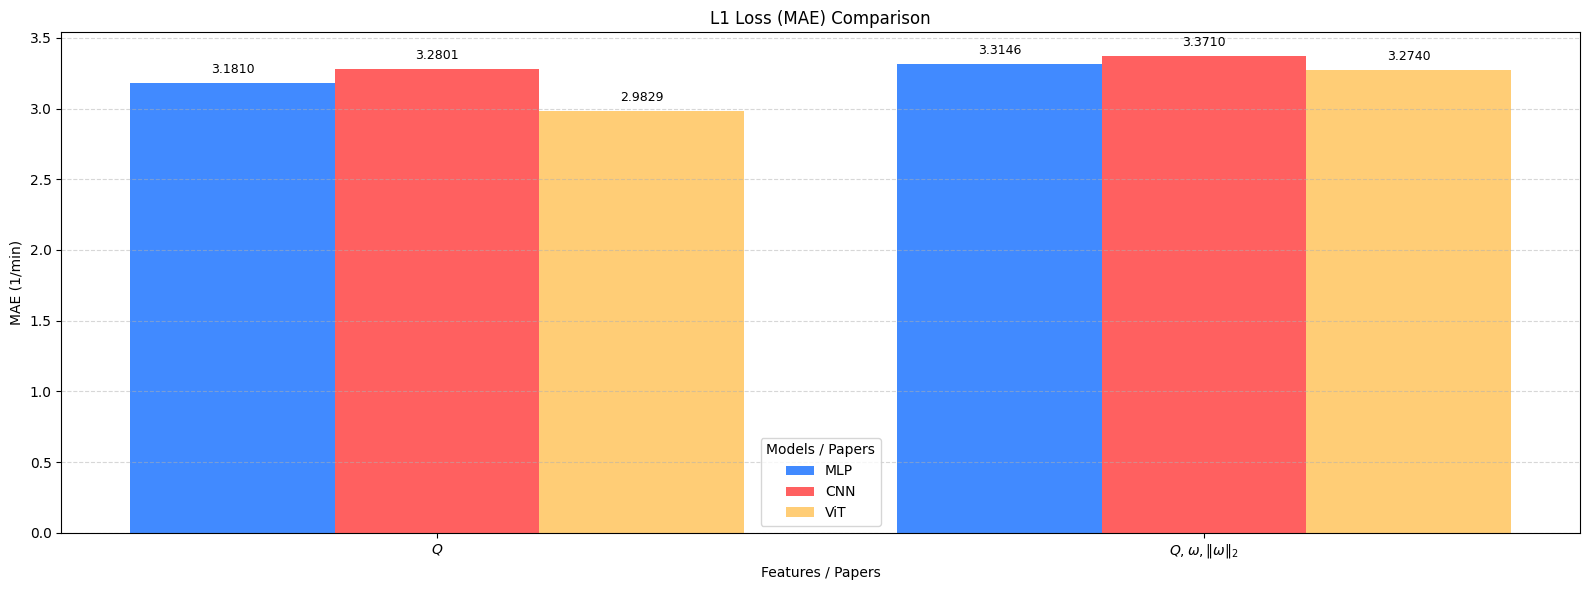

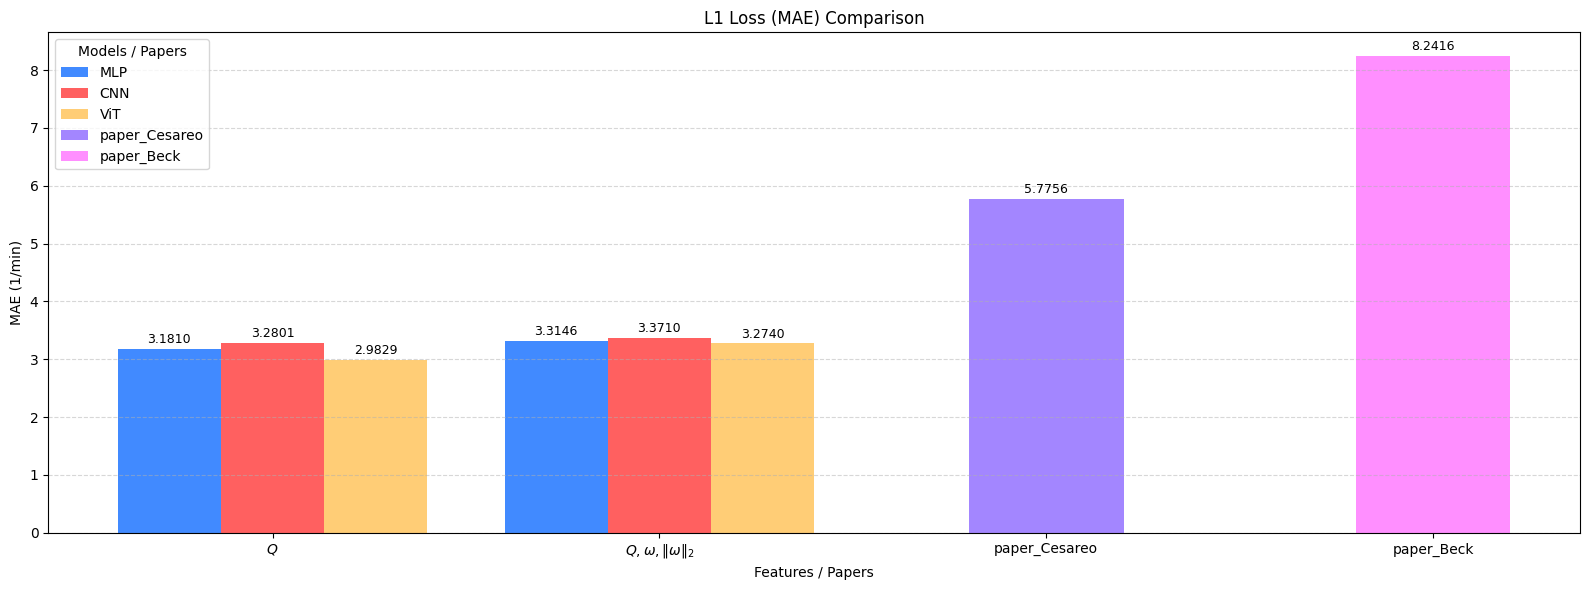

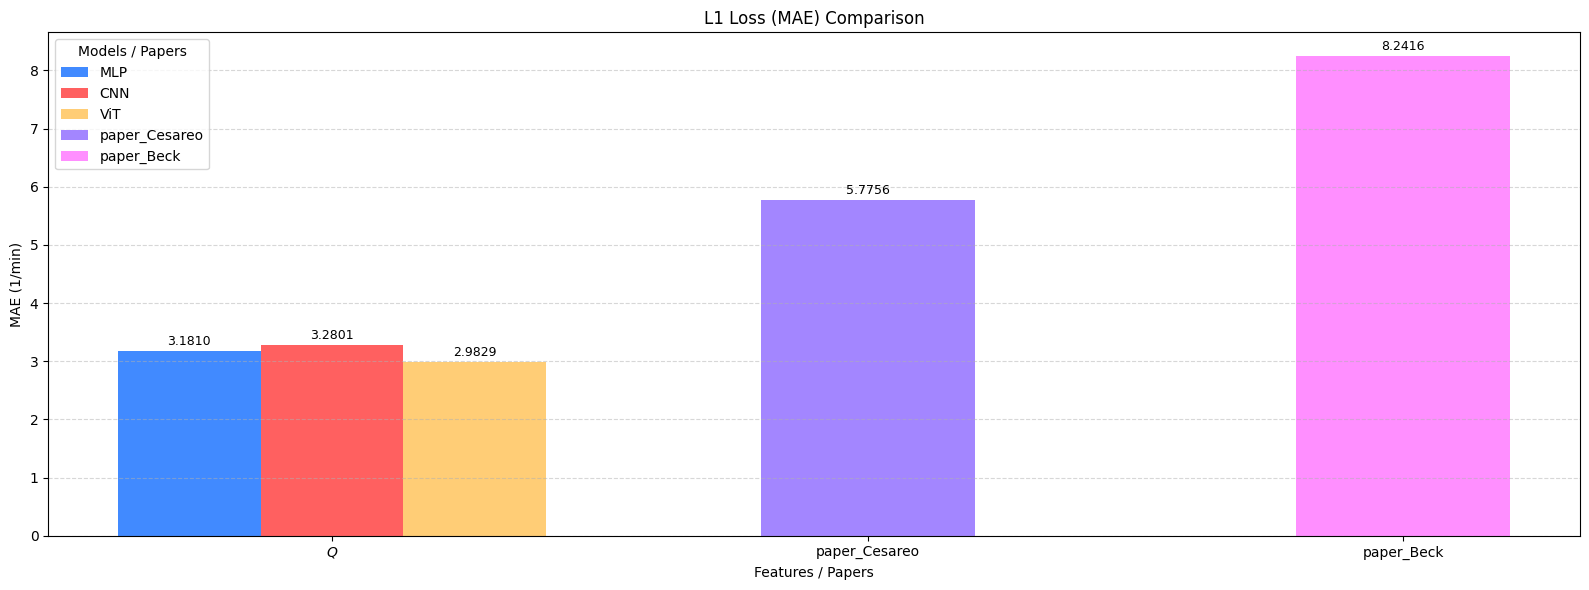

In [ ]:
def plot_mae_comparison(mae_ml, mae_paper):
    model_names = mae_ml['model_name']
    features = [key for key in mae_ml if key != 'model_name']
    
    num_models = len(model_names)
    num_features = len(features)
    
    x_labels = features + list(mae_paper.keys())
    x = np.arange(len(x_labels))
    total_bar_width = 0.8
    bar_width = total_bar_width / num_models

    fig, ax = plt.subplots(figsize=(16, 6))

    # Color
    colors = ["#418aff", "#ff6060", "#ffcd76", "#44ff70"]  # MLP, CNN, ViT_emt2, ViT_emht2
    paper_colors = ["#a386ff", "#ff8fff"]      # paper_4, paper_5

    # Model result
    for i, model in enumerate(model_names):
        values = [mae_ml[feat][i] for feat in features]
        bar_positions = x[:num_features] + i * bar_width - total_bar_width / 2 + bar_width / 2
        bars = ax.bar(bar_positions, values, width=bar_width, color=colors[i], label=model)
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.05,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    # Paper result
    for i, (paper, value) in enumerate(mae_paper.items()):
        pos = x[num_features + i]
        bar = ax.bar(pos, value, width=bar_width * 1.5, color=paper_colors[i], label=paper)
        ax.text(pos, value + 0.05, f'{value:.4f}', ha='center', va='bottom', fontsize=9)

    # ax.set_ylim(0, 4)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel("Features / Papers")
    ax.set_ylabel("MAE (1/min)")
    ax.set_title("L1 Loss (MAE) Comparison")
    ax.legend(title="Models / Papers")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

mae_ml = {
    'model_name': ["MLP", "CNN", "ViT"],
    '$Q$': MAE_Q,
    '$Q, \omega, \|\omega\|_2$': MAE_16,
}

mae_paper = {
    'paper_Cesareo': 5.7756,
    'paper_Beck': 8.2416,
}

mae_Q = {
    'model_name': ["MLP", "CNN", "ViT"],
    '$Q$': MAE_Q,
}

plot_mae_comparison(mae_ml, {})
plot_mae_comparison(mae_ml, mae_paper)
plot_mae_comparison(mae_Q, mae_paper)